In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model

In [ ]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
REBUILD = False

In [ ]:
class Classify:
    path = '/content/drive/My Drive/My_Models/plant_village/dataset/'

    sets = {}
    for file in os.listdir(path):
        full_path = os.path.join(path,file)
        sets[file] = full_path


    def make_data(self):
        data = []
        LABELS = {label : i for i,label in enumerate(os.listdir(self.path))}
        for label in LABELS:
            print(label)
            for f in tqdm(os.listdir(self.sets[label])):
                try:
                    path = os.path.join(self.sets[label],f)
                    img = cv2.imread(path ,cv2.IMREAD_COLOR)
                    img = cv2.resize(img ,(128,128))
                    data.append([np.array(img) ,LABELS[label]])
                except:
                    pass

        np.random.shuffle(data)
        images = np.array([i[0] for i in data])
        labels = np.array([i[1] for i in data])

        np.save(f"images.npy" ,images)
        np.save(f"labels.npy" ,labels)


if REBUILD:
    obj = Classify()
    obj.make_data()

In [ ]:
images = np.load('images.npy')
labels = np.load('labels.npy')

print(f"Train images shape :{images.shape}")
print(f"Train labels shape :{labels.shape}")

Train images shape :(29470, 128, 128, 3)
Train labels shape :(29470,)


In [ ]:
path = '/content/drive/My Drive/My_Models/plant_village/dataset/'
names = {i : label for i,label in enumerate(os.listdir(path))}

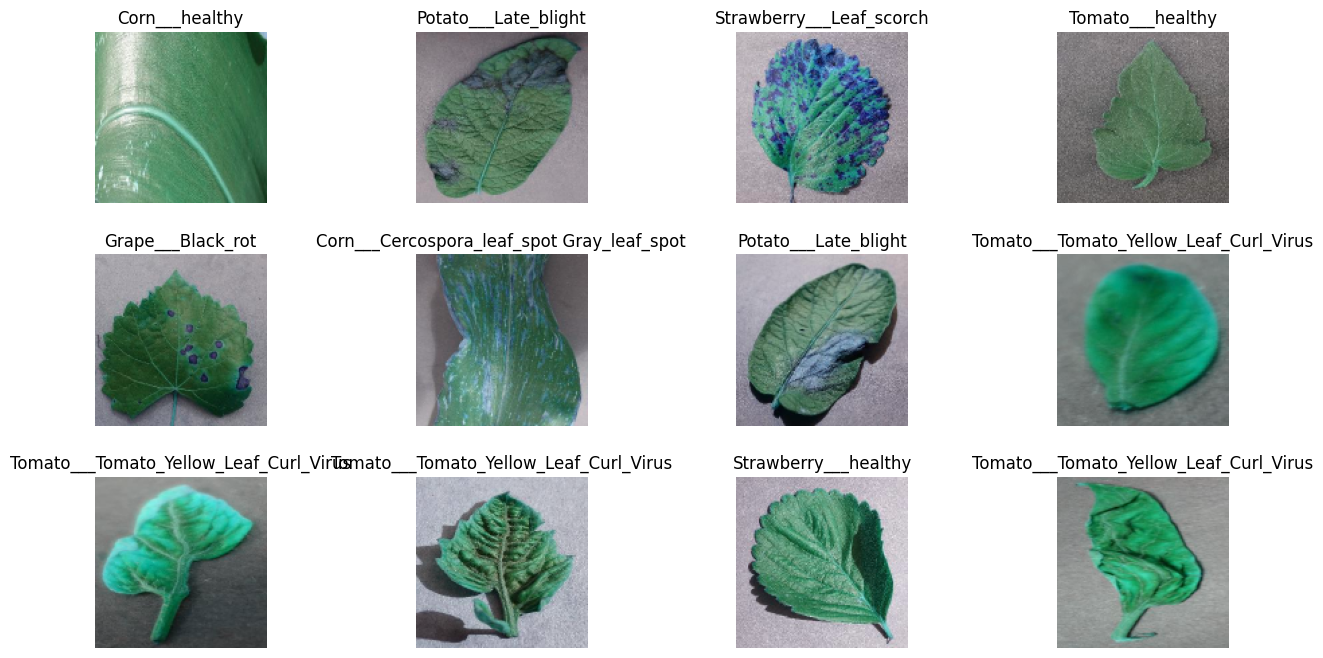

In [ ]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(3,4 ,figsize=(15,8))
for i in range(12):
    ax = axes[i//4 ,i%4]
    ax.imshow(images[i])
    ax.set_title(names[labels[i]])
    ax.axis('off')
fig.subplots_adjust(wspace=0.6, hspace=0.3)

plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
def split_dataset(images, labels, train_size,val_size, test_size):
    dataset_size = len(images)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)

    split_train = int(train_size *dataset_size)
    split_val = split_train + int(val_size * dataset_size)

    train_indices = indices[:split_train]
    val_indices = indices[split_train:split_val]
    test_indices = indices[split_val:]

    return train_indices, val_indices, test_indices


In [ ]:
def create_dataloaders(images,labels,train_size=0.7 , val_size=0.15 , test_size=0.15):
    train_indices, val_indices, test_indices = split_dataset(images, labels, train_size, val_size, test_size)

    train_dataset = CustomDataset(images[train_indices], labels[train_indices], transform=transform)
    val_dataset = CustomDataset(images[val_indices], labels[val_indices], transform=transform)
    test_dataset = CustomDataset(images[test_indices], labels[test_indices], transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
train_loader , val_loader , test_loader = create_dataloaders(images,labels)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
model = models.mobilenet_v2(pretrained = True)

for param in model.features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
num_classes = 24
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

In [ ]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=24, bias=True)
)


In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 3
train_loss_history=[]
val_loss_history=[]

for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  for i ,(inputs,labels) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss_ = loss(outputs,labels)
    loss_.backward()
    optimizer.step()

    running_loss = running_loss + loss_.item()
    if (i+1)%60==0:
       print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss /60:.4f}')
       train_loss_history.append(running_loss)
       running_loss = 0.0

  model.eval()
  val_loss=0.0
  with torch.no_grad():
    for k,(inputs,labels) in enumerate(val_loader):
      outputs = model(inputs)
      loss_ = loss(outputs,labels)
      val_loss = val_loss + loss_.item()
      if (k+1)%30==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Val Step [{k + 1}/{len(val_loader)}], Val Loss: {val_loss /30:.4f}')
        val_loss_history.append(val_loss)
        val_loss = 0.0



Epoch [1/3], Step [60/645], Loss: 1.7510
Epoch [1/3], Step [120/645], Loss: 0.7569
Epoch [1/3], Step [180/645], Loss: 0.4908
Epoch [1/3], Step [240/645], Loss: 0.3531
Epoch [1/3], Step [300/645], Loss: 0.3210
Epoch [1/3], Step [360/645], Loss: 0.2696
Epoch [1/3], Step [420/645], Loss: 0.2316
Epoch [1/3], Step [480/645], Loss: 0.2103
Epoch [1/3], Step [540/645], Loss: 0.2071
Epoch [1/3], Step [600/645], Loss: 0.1929
Epoch [1/3], Val Step [30/139], Val Loss: 0.1484
Epoch [1/3], Val Step [60/139], Val Loss: 0.1620
Epoch [1/3], Val Step [90/139], Val Loss: 0.1218
Epoch [1/3], Val Step [120/139], Val Loss: 0.1247
Epoch [2/3], Step [60/645], Loss: 0.1598
Epoch [2/3], Step [120/645], Loss: 0.1589
Epoch [2/3], Step [180/645], Loss: 0.1650
Epoch [2/3], Step [240/645], Loss: 0.1547
Epoch [2/3], Step [300/645], Loss: 0.1273
Epoch [2/3], Step [360/645], Loss: 0.1397
Epoch [2/3], Step [420/645], Loss: 0.1396
Epoch [2/3], Step [480/645], Loss: 0.1244
Epoch [2/3], Step [540/645], Loss: 0.1294
Epoch [

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


In [ ]:

model.save('/content/drive/MyDrive/disease_model')

In [ ]:
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import ipywidgets as widgets
from io import BytesIO

model.eval()

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = Image.open(file)
    image = transform(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        prediction = model(image)[0]

    prediction = F.softmax(prediction, dim=0)
    predicted_class = prediction.argmax().item()

    with out:
        predicted_disease = names[predicted_class]
        print(filename + " belongs to "+predicted_disease +" category")

def on_upload_change(change):

    items = change.new
    for item in items:
        file_jpgdata = BytesIO(item['content'])
        file_predict(item['name'], file_jpgdata, out)

# Run the interactive widget
uploader.observe(on_upload_change, names='value')
